# Ridge regression with polynomial features of degree 3

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import pickle
import os

In [2]:
model_name = "ridge_poly3"
aml_dir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']
train = pd.read_csv(aml_dir + 'nyc_demand_train.csv', parse_dates=['timeStamp'])

Create model pipeline:
- create polynomial features of degree 3. This means that for each pair of features $(x_1, x_2)$, the output features are $(x_1,  x_1^2,  x_1^3,  x_2,  x_2^2,  x_2^3,  x_1x_2^2,  x_1^2x_2)$. Note: numerical categorical features are not one-hot encoded because this would increase the dimensions of the input prohibitively.
- use grid search to find optimal values for the alpha parameter 

In [3]:
X = train.drop(['demand', 'timeStamp'], axis=1)

In [4]:
regr = Ridge(fit_intercept=False, normalize=True)
poly = PolynomialFeatures(3)
tscv = TimeSeriesSplit(n_splits=3)

In [5]:
param_grid = {'alpha': [ 1e-4, 1e-3, 1e-2, 0.1, 1.0]}
regr_cv = GridSearchCV(estimator=regr,
                            param_grid=param_grid,
                            scoring='neg_mean_squared_error',
                            iid=False,
                            verbose=2,
                            n_jobs=-1)
regr_pipe = Pipeline([('poly', poly), ('regr_cv', regr_cv)])
regr_pipe.fit(X, y=train['demand'])

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   29.8s finished


Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('regr_cv', GridSearchCV(cv=None, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001),
       ...*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=2))])

Save model to AML shared directory

In [7]:
with open(aml_dir + model_name + '.pkl', 'wb') as f:
    pickle.dump(regr_pipe, f)

### Cross validation results

In [8]:
cv_results = pd.DataFrame(regr_pipe.named_steps['regr_cv'].cv_results_)
cv_results.sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_alpha,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
4,3.496018,0.045509,-2335.383383,-1716.224334,1,{'alpha': 1.0},1,-2757.385827,-1655.054086,-2173.792776,-1708.902496,-2074.971545,-1784.716422,0.961480,0.007075,301.115655,53.187012
3,5.211334,0.049334,-2344.101723,-1715.094443,0.1,{'alpha': 0.1},2,-2778.885879,-1654.167632,-2171.256625,-1707.422242,-2082.162664,-1783.693456,0.288442,0.007442,309.582924,53.156259
2,6.230664,0.064670,-2352.859898,-1714.083592,0.01,{'alpha': 0.01},3,-2814.437780,-1653.646304,-2179.109662,-1706.074609,-2065.032253,-1782.529864,0.492969,0.007028,329.690784,52.920386
1,6.183000,0.057835,-2368.242088,-1713.681495,0.001,{'alpha': 0.001},4,-2864.737802,-1653.436617,-2191.288546,-1705.597436,-2048.699916,-1782.010432,0.341903,0.003519,355.868772,52.800382
0,4.977605,0.081504,-2392.668035,-1713.590274,0.0001,{'alpha': 0.0001},5,-2918.779540,-1653.424662,-2208.334979,-1705.387950,-2050.889586,-1781.958211,1.834457,0.009275,377.529027,52.793162


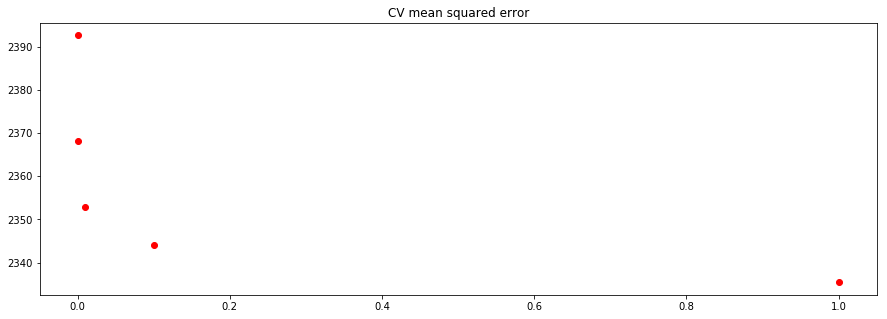

In [9]:
plt.figure(figsize=(15, 5))
plt.plot(cv_results['param_alpha'], -cv_results['mean_test_score'], 'ro')
plt.title('CV mean squared error')
plt.show()